In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
import subprocess
from scipy.misc import imread
%matplotlib inline

from train import build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
#from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles

In [2]:
hypes_file = './hypes/default.json'
with open(hypes_file, 'r') as f:
    H = json.load(f)
true_idl = './data/brainwash/brainwash_val.idl'
pred_idl = './output/val_%s.idl' % os.path.basename(hypes_file).replace('.json', '')
true_annos = al.parse(true_idl)

In [3]:
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')
saver = tf.train.Saver()

In [7]:
g_boxes = []
g_confs = []

In [14]:
restore_file = "output/pascal_2016_03_14_08.53/save.ckpt-1000"
restore_file = "output/default_2016_03_14_08.26/save.ckpt-1000"

0


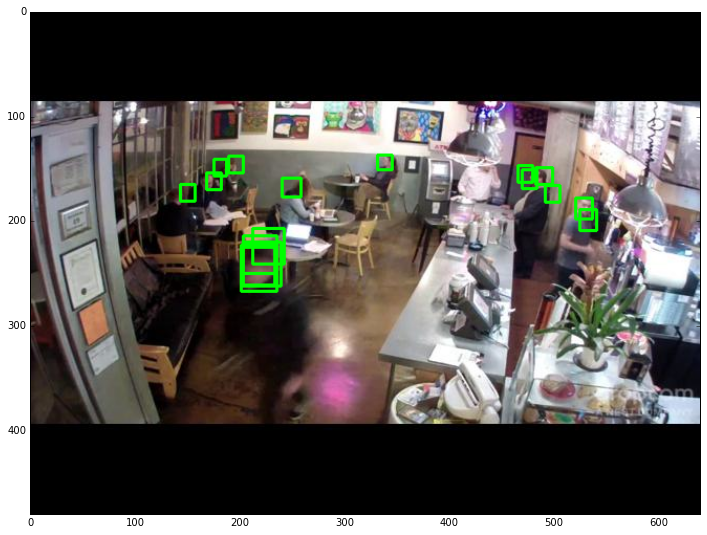

In [15]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    if H['arch']['use_lstm']:
        saver.restore(sess, 'data/lstm/save.ckpt-320000')
    else:
        saver.restore(sess, restore_file)
    annolist = al.AnnoList()
    for i in range(0, 1, 1):
        true_anno = true_annos[i]
        img = imread('./data/brainwash/%s' % true_anno.imageName)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        g_boxes = np_pred_boxes
        g_confs = np_pred_confidences
        pred_anno = al.Annotation()
        pred_anno.imageName = true_anno.imageName
        new_img, rects = add_rectangles([img], np_pred_confidences, np_pred_boxes,
                                        H["arch"], use_stitching=False, rnn_len=H['arch']['rnn_len'], min_conf=0.3)
    
        pred_anno.rects = rects
        annolist.append(pred_anno)

        if i % 7 == 0 and i < 50:
            fig = plt.figure(figsize=(12, 12))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)


In [16]:
g_boxes

array([[[-40.66640091, -31.38646126,  48.07712173,  74.53475189]],

       [[-30.23088837, -35.78916168,  52.31882858,  69.55950165]],

       [[-31.05864525, -42.23682404,  58.14197159,  72.18507385]],

       ..., 
       [[-23.56817055,   2.71944475,  24.62483597,  42.10301208]],

       [[-21.00294685,   0.0791409 ,  24.25268936,  46.77659988]],

       [[-14.63171196,  -6.03528452,  20.93182182,  50.34143829]]], dtype=float32)

In [9]:
g_boxes

array([[[ -6.77275276,  15.03758717,   4.23707533,  -7.27432299]],

       [[ -6.65928125,  19.06362915,   9.11090565, -13.49691486]],

       [[ -4.61766529,  26.8371067 ,  11.38027763, -14.46160984]],

       ..., 
       [[-12.45978546,   8.94641399,  -6.48683834, -10.61517143]],

       [[-10.55844784,   2.09084082,  -4.90678692, -11.53807831]],

       [[ -8.23757267,  -1.39205396,  -5.70733261,  -8.93842411]]], dtype=float32)

In [10]:
g_confs

array([[  9.99938607e-01,   6.14091550e-05],
       [  9.99999046e-01,   1.01127432e-06],
       [  1.00000000e+00,   7.40798800e-09],
       [  1.00000000e+00,   6.85338286e-10],
       [  1.00000000e+00,   3.84464127e-10],
       [  1.00000000e+00,   2.45488879e-10],
       [  1.00000000e+00,   7.70089201e-11],
       [  1.00000000e+00,   2.64085264e-11],
       [  1.00000000e+00,   2.60957315e-11],
       [  1.00000000e+00,   5.89629665e-11],
       [  1.00000000e+00,   1.70563286e-10],
       [  1.00000000e+00,   8.59852745e-10],
       [  1.00000000e+00,   3.33514660e-09],
       [  1.00000000e+00,   2.04409956e-09],
       [  1.00000000e+00,   1.40720224e-09],
       [  1.00000000e+00,   1.28821420e-09],
       [  1.00000000e+00,   1.82970317e-09],
       [  1.00000000e+00,   1.19229515e-08],
       [  9.99997616e-01,   2.38561620e-06],
       [  9.99970436e-01,   2.95516820e-05],
       [  9.99999642e-01,   3.49709325e-07],
       [  1.00000000e+00,   4.24338065e-11],
       [  

saving:  ./output/val_lstm.idl
$ ./utils/annolist/doRPC.py --minOverlap 0.500000 ./data/brainwash/brainwash_val.idl ./output/val_lstm.idl
Minimum width: 0 height: 0
Asorting too large/ too small detections
minWidth: 0
minHeight: 0
maxWidth:  inf
maxHeight:  inf
#Annotations: 3318
Setting up graphs ...
missingFrames:  0
Number of detections on annotated frames:  3728
Sorting scores ...
Gradually decrease score ...
saving:
/hr1/h/box/output/rpc-val_lstm_overlap0.5.txt

$ ./utils/annolist/plotSimple.py /hr1/h/box/output/rpc-val_lstm_overlap0.5.txt --output output/results.png


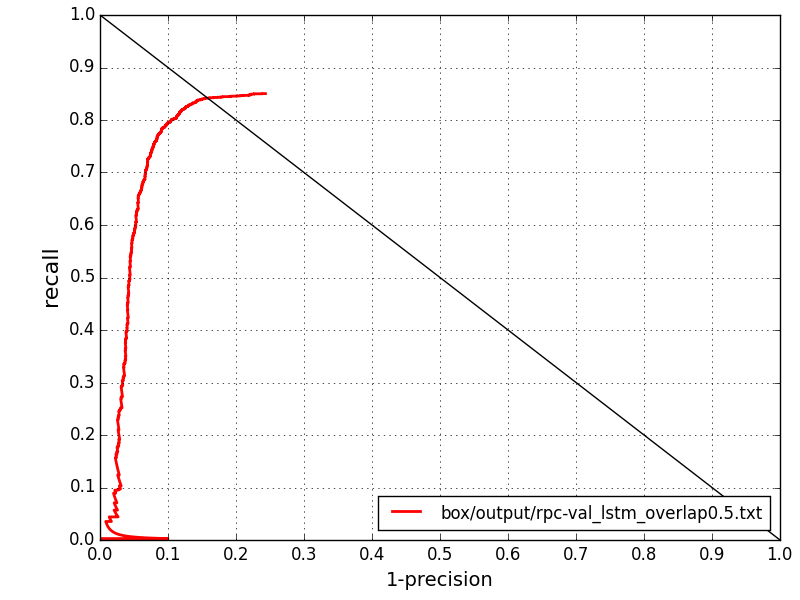

In [5]:
annolist.save(pred_idl)
iou_threshold = 0.5
rpc_cmd = './utils/annolist/doRPC.py --minOverlap %f %s %s' % (iou_threshold, true_idl, pred_idl)
print('$ %s' % rpc_cmd)
rpc_output = subprocess.check_output(rpc_cmd, shell=True)
print(rpc_output)
txt_file = [line for line in rpc_output.split('\n') if line.strip()][-1]
output_png = 'output/results.png'
plot_cmd = './utils/annolist/plotSimple.py %s --output %s' % (txt_file, output_png)
print('$ %s' % plot_cmd)
plot_output = subprocess.check_output(plot_cmd, shell=True)
from IPython.display import Image
Image(filename=output_png) 